In [ ]:
!pip install tensorflow_decision_forests

In [38]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow_decision_forests.keras import RandomForestModel

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Checking TensorFlow packages
print("TensorFlow: v" + tf.__version__)
print("TensorFlow Decision Forests: v" + tfdf.__version__)
# Checking GPU support
print(f'Number of available GPUs: {len(tf.config.list_physical_devices("GPU"))}')

TensorFlow: v2.16.2
TensorFlow Decision Forests: v1.9.2
Number of available GPUs: 1


In [5]:
train_df = pd.read_csv('./data/train.csv')

In [6]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [7]:
train_df = train_df.drop('Id', axis=1)
train_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [10]:
input_features = list(train_df.columns)
input_features.remove('SalePrice')
len(input_features)

79

<Figure size 900x800 with 0 Axes>

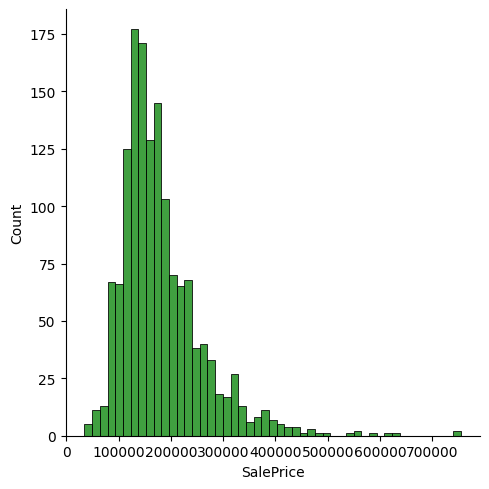

In [16]:
# Plotting house distribution
train_df['SalePrice'].describe()
plt.figure(figsize=(9,8))
sns.displot(train_df['SalePrice'], color="g");

[dtype('O'), dtype('float64'), dtype('int64')]


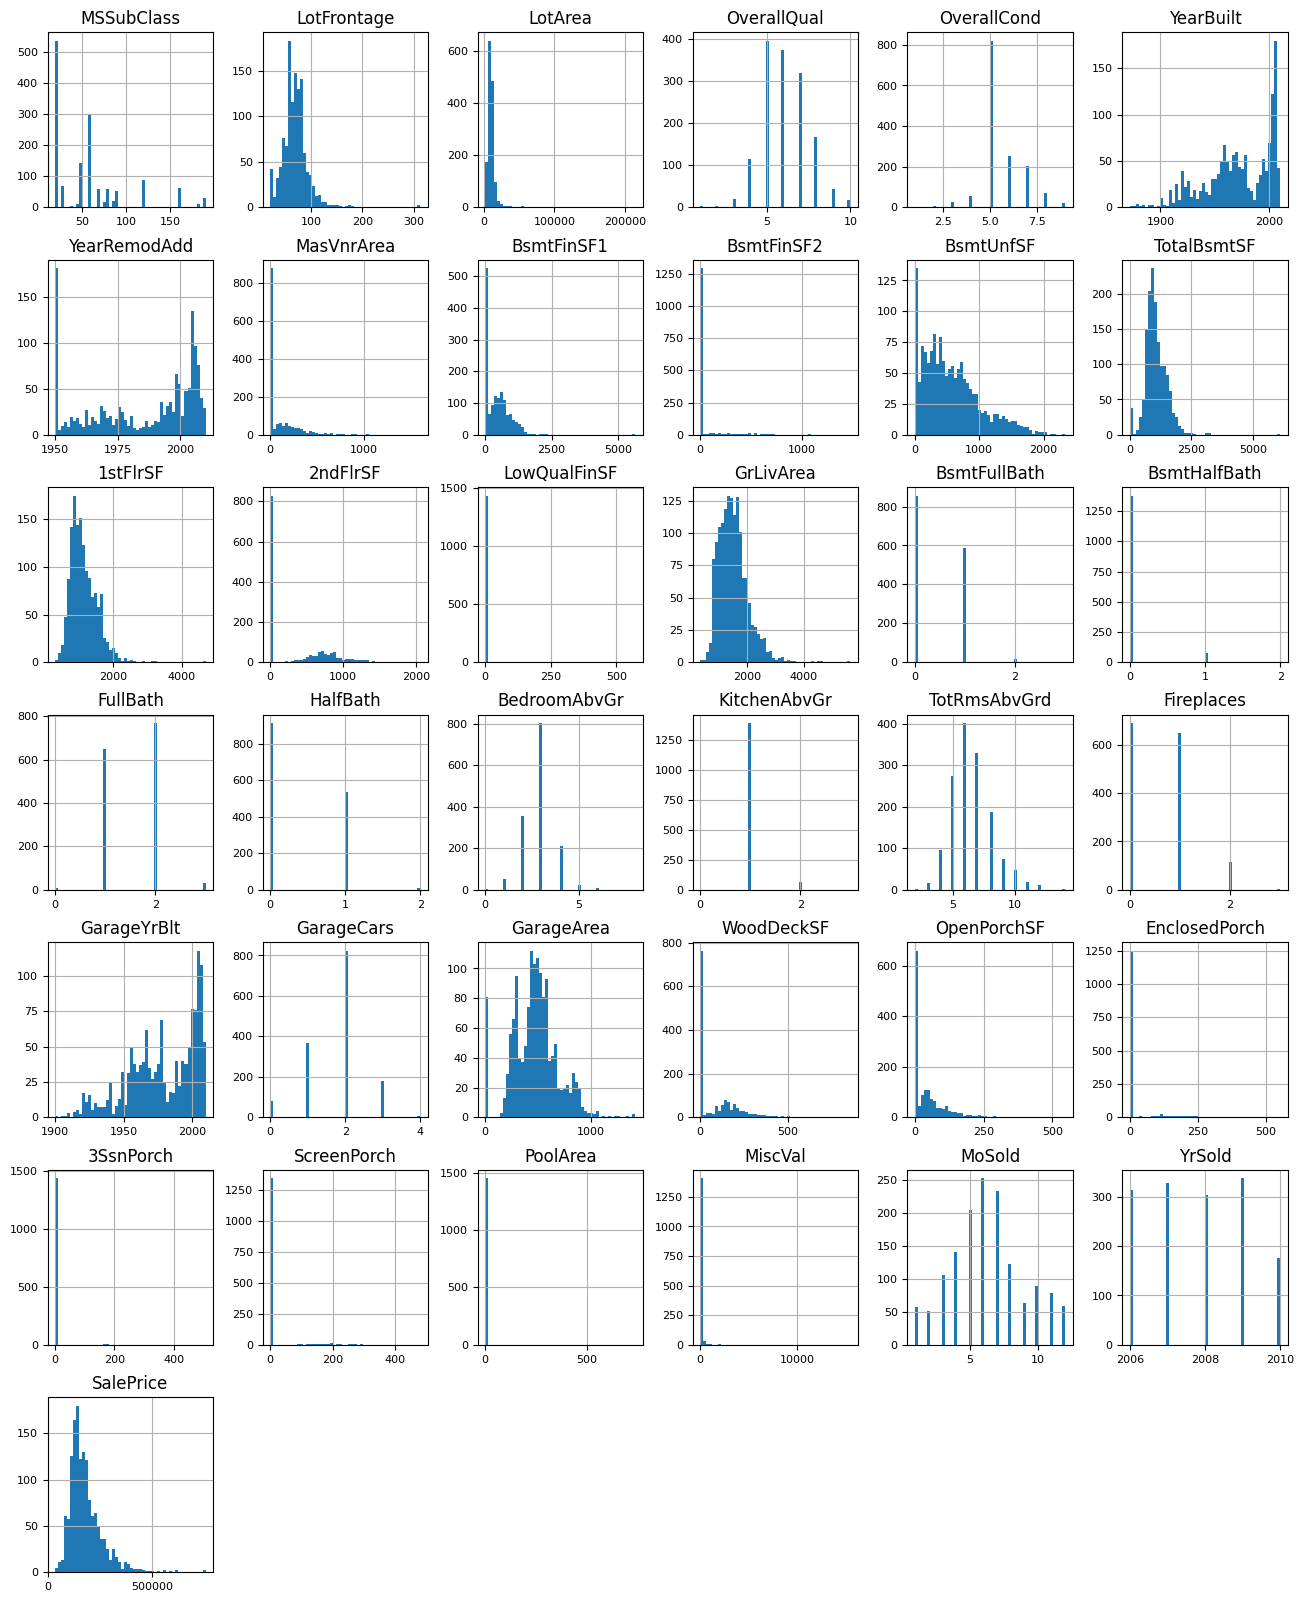

In [27]:
# numerical data distribution
print(list(set(train_df.dtypes.tolist())))
df_num = train_df.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [36]:
# splitting dataset
def split_ds(ds, test_ratio=0.3):
  test_indicies = np.random.rand(len(ds)) < test_ratio
  return ds[~test_indicies], ds[test_indicies]

train_ds_pd, val_ds_pd = split_ds(train_df)
print(f'Training examples: {len(train_ds_pd)}, validation examples: {len(val_ds_pd)}')

Training examples: 1018, validation examples: 442


In [37]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)

In [88]:
model = RandomForestModel(
    task = tfdf.keras.Task.REGRESSION,
    max_depth=-1
)
model.compile(metrics=['mse'])

Use /tmp/tmpgthk1kcl as temporary training directory


In [89]:
model.fit(train_ds, verbose=1)

Reading training dataset...
Training dataset read in 0:00:00.840850. Found 1018 examples.
Training model...
Model trained in 0:00:02.598558
Compiling model...
Model compiled.


In [90]:
# plotting model
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

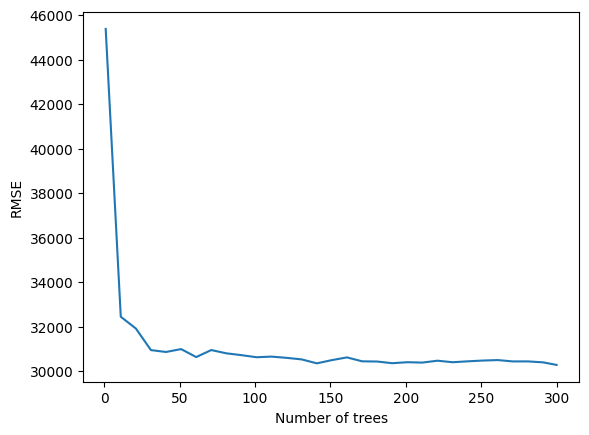

In [91]:
# training success
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.show()

In [92]:
inspector = model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1018, accuracy=None, loss=None, rmse=30274.5476719345, ndcg=None, aucs=None, auuc=None, qini=None)

In [93]:
# evaluation
evaluation = model.evaluate(x=val_ds, return_dict=True, verbose=1)

for name, value in evaluation.items():
  print(f'{name}: {value:.4f}')

1/1 [==============================] - 0s 465ms/step - loss: 0.0000e+00 - mse: 845833472.0000
loss: 0.0000
mse: 845833472.0000


In [84]:
# variable importances
print(f"Available variable importances: {', '.join(inspector.variable_importances().keys())}")

Available variable importances: SUM_SCORE, INV_MEAN_MIN_DEPTH, NUM_AS_ROOT, NUM_NODES


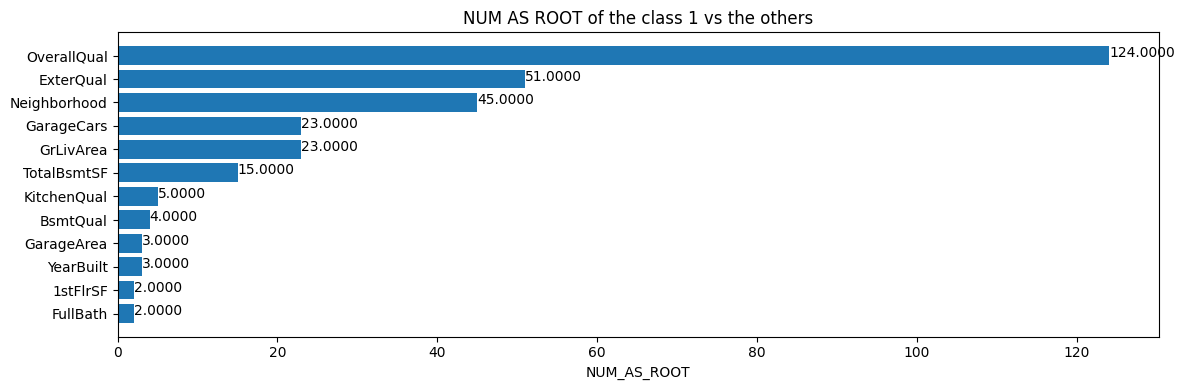

In [85]:
plt.figure(figsize=(12,4))
variable_importances = inspector.variable_importances()["NUM_AS_ROOT"]

feature_names = [v[0][0] for v in variable_importances]
feature_importances = [v[1] for v in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel("NUM_AS_ROOT")
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [86]:
test_df = pd.read_csv('./data/test.csv')
ids = test_df.pop('Id')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task= tfdf.keras.Task.REGRESSION)

preds = model.predict(test_ds)
output = pd.DataFrame({
    'Id': ids,
    'SalePrice': preds.squeeze()
  })

output.head(5)
output.to_csv('submission.csv', index=False)

2/2 [==============================] - 1s 24ms/step
